Donde entrenamos el modelo que liga a profesores de Grace con perfiles de MisProfes

In [7]:
import requests, pickle, re, os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from thefuzz import fuzz

from misProfesScrapper import MisProfesScrapper, get_features
from graceScrapper import GraceScrapper
from utils import claveToDepto, normalize_text

os.makedirs("data/scrappers", exist_ok=True)

random_state = 42
np.random.seed(random_state)

In [4]:
# Load scrapper data

# misProfesUrl = "https://www.misprofesores.com/escuelas/ITAM-Instituto-Tecnologico-Autonomo-de-Mexico_1003"
# profesScrapper = MisProfesScrapper(misProfesUrl)
# profesScrapper.scrap()
# with open("data/scrappers/mis_profes.pkl", "wb") as f:
#     pickle.dump(profesScrapper, f)

# or load
profesScrapper = pickle.load(open("data/scrappers/mis_profes.pkl", "rb"))
len(profesScrapper.data)


# graceScrapper = GraceScrapper()
# graceScrapper.scrap()

# with open("data/scrappers/grace.pkl", "wb") as f:
#     pickle.dump(graceScrapper, f)

# or load
graceScrapper = pickle.load(open("data/scrappers/grace.pkl", "rb"))

id_to_info = {}
for info in profesScrapper.data.values():
    id_to_info[info['id']] = info
# id_to_info

In [33]:
# Specific preprocessing for training / testing 
# Deployment will have different ways of constructing columns
# Note: final preprocessing will be done in the pipeline

df = pd.read_csv('data/labelled_matches.csv')

# Get id, name, and depto from MisProfes link
def add_mis_profes_info(row):

    if isinstance(row['Link MisProfes'], str):
        id = row['Link MisProfes'].split('_')[-1]
        nombre = id_to_info[id]['nombre']
        depto = id_to_info[id]['depto']
        n = id_to_info[id]['n']
    else:
        id, nombre, depto, n = None, None, None, None

    return pd.Series({
        'Id MisProfes': id,
        'Nombre MisProfes': nombre,
        'Depto MisProfes': depto,
        'no. de reviews': n
    })
df = pd.concat([df, df.apply(add_mis_profes_info, axis = 1)], axis = 1)

# Train on first 100, test on next 50
training_df = df.iloc[:100].copy()
test_df = df.iloc[100:150].copy()

def prep(df, k = 10, training = True):

    if training: # keep only those that matched as positives
        df = df[~df['Id MisProfes'].isna()]
        df['Match'] = True
    else:
        df['Match'] = df['Id MisProfes'].notna()

    # For training, get negative examples by randomly sampling k other misProfes for every grace one
    negatives = []
    for _, row in df.iterrows():

        id = row['Id MisProfes']

        if training and (id is None or pd.isna(id)):
            continue
        
        neg_ids = list(id_to_info.keys())
        if id in neg_ids:
            neg_ids.remove(id)

        for neg_id in np.random.choice(neg_ids, k) if training else neg_ids:

            neg_row = row.copy()
            neg_row.update({
                'Id MisProfes': neg_id,
                'Link MisProfes': id_to_info[neg_id]['link'],
                'Nombre MisProfes': id_to_info[neg_id]['nombre'],
                'Depto MisProfes': id_to_info[neg_id]['depto'],
                'Match': False
            })
            negatives.append(neg_row)

    negatives = pd.DataFrame(negatives)
    df = pd.concat([df, negatives], ignore_index = True)

    # Extract deparments from claves de clases
    df['Deptos Grace'] = df['Claves Clases'].apply(lambda x: ','.join(set([claveToDepto[c.split('-')[0]] for c in x.split(', ')])))

    # Extract features
    df = pd.concat([df, get_features(df)], axis = 1)

    # shuffle the dataframe
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df


training_df = prep(training_df)
test_df = prep(test_df, training = False)

/var/folders/0r/dny0wtpd4412y54gp84twsj40000gn/T/ipykernel_35569/4049887974.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Match'] = True


Text(0.5, 0, 'Token Sort Ratio between Names')

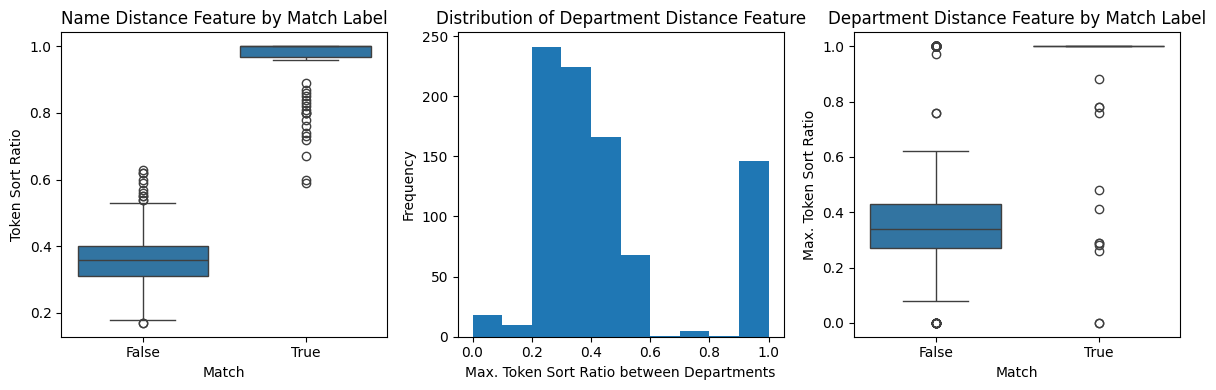

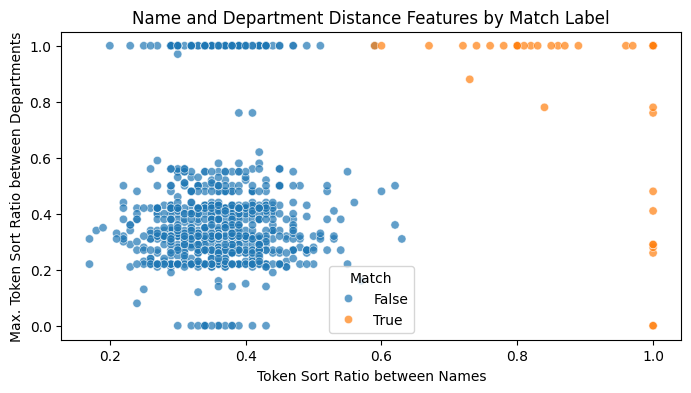

In [15]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax = ax1

sns.boxplot(data = training_df, x = 'Match', y = 'name_token_sort', ax=ax)
ax.set_ylabel('Token Sort Ratio')
ax.set_title('Name Distance Feature by Match Label')

ax = ax2
ax.hist(training_df['dept_max_ratio'])

ax.set_title('Distribution of Department Distance Feature')
ax.set_xlabel('Max. Token Sort Ratio between Departments')
ax.set_ylabel('Frequency')

ax = ax3
sns.boxplot(data = training_df, x = 'Match', y = 'dept_max_ratio', ax=ax)
ax.set_ylabel('Max. Token Sort Ratio')
ax.set_title('Department Distance Feature by Match Label')

plt.tight_layout()

plt.figure(figsize=(8, 4))
sns.scatterplot(data = training_df, x = 'name_token_sort', y = 'dept_max_ratio', hue = 'Match', alpha=0.7)
plt.title('Name and Department Distance Features by Match Label')
plt.ylabel('Max. Token Sort Ratio between Departments')
plt.xlabel('Token Sort Ratio between Names')

In [16]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_score

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline


pipeline = Pipeline([
    ('custom', FunctionTransformer(get_features)),
    ('clf', LogisticRegression(random_state = random_state)),
], memory = './cache')


cv_results = cross_validate(pipeline, X = training_df, y = training_df['Match'], cv = 5, scoring = ['accuracy', 'roc_auc', 'precision', 'recall', 'f1'])
{k: float(v.mean()) for k, v in cv_results.items() if 'test' in k}

{'test_accuracy': 0.9943181818181819,
 'test_roc_auc': 1.0,
 'test_precision': 1.0,
 'test_recall': 0.9375,
 'test_f1': 0.9649769585253456}

In [17]:
pipeline.fit(training_df, training_df['Match'])
print(pipeline.named_steps['clf'].coef_)

preds = pipeline.predict(test_df)
preds_prob = pipeline.predict_proba(test_df)[:, 1]

# print metrics
y_test = test_df['Match']
print("F1 Score:", f1_score(y_test, preds))
print("Accuracy:", accuracy_score(y_test, preds))
print("ROC AUC:", roc_auc_score(y_test, preds_prob))
print("Precision:", precision_score(y_test, preds))

# save clf w pickle
with open('match_pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

[[4.97379116 4.75767069 2.48124942]]
F1 Score: 0.8809523809523809
Accuracy: 0.9998647936074417
ROC AUC: 0.999972424156023
Precision: 0.8222222222222222


In [18]:
def match_a(test_df, clf, threshold = 0.5):

    out = []

    # Predice pareja de cada profesor de Grace
    for nombre_grace in test_df['Nombre Grace'].unique():

        _df = test_df[test_df['Nombre Grace'] == nombre_grace]
        
        has_match = _df['Match'].sum() > 0
        true_match_id = _df[_df['Match']]['Id MisProfes'].values[0] if has_match else None

        preds = clf.predict_proba(_df)[:, 1]

        pred_match_id = None
        if preds.max() > threshold:
            pred_match_id = _df.iloc[np.argmax(preds)]['Id MisProfes']
        
        out.append({
            'Nombre Grace': nombre_grace,
            'Id MisProfes': pred_match_id,
            'max prob': preds.max(), # if pred_match_id else None,
            # TMP
            'token_sort_ratio': _df.iloc[np.argmax(preds)]['name_token_sort'],
            'max dept ratio': _df.iloc[np.argmax(preds)]['dept_max_ratio'],
            'name argmax': _df.iloc[np.argmax(preds)]['Nombre MisProfes'],
            'Nombre MisProfes': _df[_df['Id MisProfes'] == pred_match_id]['Nombre MisProfes'].values[0] if pred_match_id else None,

            'Correct': pred_match_id == true_match_id,
            'Incorrect Match': pred_match_id is not None and pred_match_id != true_match_id,
            'Incorrect No Match': pred_match_id is None and pred_match_id != true_match_id,
        })


    return pd.DataFrame(out)

res = match_a(test_df, pipeline, threshold = 0.5)

res['Correct'].mean(), res['Incorrect Match'].mean(), res['Incorrect No Match'].mean(), res['Id MisProfes'].notna().mean()

(0.92, 0.04, 0.04, 0.76)

In [31]:
training_df

,Nombre Grace,Claves Clases,Link MisProfes,Unnamed: 3,Id MisProfes,Nombre MisProfes,Depto MisProfes,Match,Deptos Grace,name_token_sort,name_lev_ratio,dept_max_ratio
0,ABIMAEL JAVIER BENGOCHEA CRUZ,"MAT-24211, MAT-12220",https://www.misprofesores.com/profesores/Max-K...,NaN,15789,Max Kaiser Aranda,Derecho,False,MATEMATICAS,0.39,0.43,0.22
1,MARIA LUISA GRUNBERGER STERN,"CON-12001, CON-12003",https://www.misprofesores.com/profesores/Martí...,NaN,22720,Martín Mora Ledesma,estudios generales,False,CONTABILIDAD,0.47,0.43,0.27
2,MARIA CANDELAS RAMIREZ,"CON-10001, CON-10112, CON-10003",https://www.misprofesores.com/profesores/Maria...,NaN,10751,María Candelas Ramírez,Contabilidad,True,CONTABILIDAD,1.00,1.00,1.00
3,EMILIO GUTIERREZ FERNANDEZ,"ECO-18101, ECO-10204, ECO-10202",https://www.misprofesores.com/profesores/Alexi...,NaN,58695,Alexis Cherem Maus,Ciencia Política,False,ECONOMIA,0.36,0.36,0.42
4,CRISTHIAN JOSE MANUEL SEMINARIO AMEZ,"ECO-22105, ECO-10518",https://www.misprofesores.com/profesores/Silva...,https://www.misprofesores.com/profesores/Crist...,20718,Silvano Antonio Espíndola Parra,Estudios Generales,False,ECONOMIA,0.39,0.45,0.31
...,...,...,...,...,...,...,...,...,...,...,...,...
875,MARIA DE LOURDES ALICIA DOMENZAIN ORTEGA,COM-16305,https://www.misprofesores.com/profesores/Lourd...,NaN,16997,Lourdes Domenzain,Computacion,True,COMPUTACION,0.60,0.60,1.00
876,JOSE FRANCISCO TUDON MALDONADO,"ADM-12350, ADM-15582",https://www.misprofesores.com/profesores/Silvi...,NaN,10847,Silvia del Carmen Guardati Buemo,Computación,False,ADMINISTRACION,0.29,0.35,0.56
877,IGNACIO NORBERTO LOBATO GARCIA MIJAN,"EST-21104, ECO-20514",https://www.misprofesores.com/profesores/Ricar...,NaN,10782,Ricardo Samaniego Breach,Economía,False,"ECONOMIA,ESTADISTICA",0.43,0.37,1.00
878,JORGE MONROY JIMENEZ,"MAT-14280, MAT-14300, MAT-14281, MAT-14301",https://www.misprofesores.com/profesores/Juan-...,NaN,179255,Juan Mármol,Computación,False,MATEMATICAS,0.39,0.32,0.36


In [19]:
import json
# datos_profes = json.load(open('../tmp.json', 'r'))['profesores']
datos_profes = json.load(open('../tmp.json', 'r'))

# nombre grace -> misProfes id
matches_deployed = {nombre: info['link'].split('_')[-1] if 'link' in info else None for nombre, info in datos_profes.items()}
len(matches_deployed)

matches_local = dict(zip(res['Nombre Grace'], res['Id MisProfes']))

In [20]:
diffs = 0
total = 0
for nombre, match_id in matches_deployed.items():
    if nombre not in matches_local: continue
    if match_id != matches_local[nombre]:
        print(nombre, matches_local[nombre], match_id,datos_profes[nombre])
    diffs += match_id != matches_local[nombre]
    total += 1

diffs, len(matches_deployed), len(matches_local), total

(0, 333, 50, 37)